# 📊 **Uso del Web Scraping para la Obtención de Número de Seguidores de Cuentas de X** 🚀

Este proyecto se centra en la obtención y análisis de los datos de seguidores de cuentas en X utilizando técnicas de web scraping.

---

## 🧹 **1. Limpieza de Datos - `limpiar.py`**

En esta sección, realizamos la limpieza de los datos obtenidos a través del web scraping. El código de la función `limpiar.py` se encarga de eliminar valores nulos, duplicados y corregir cualquier inconsistencia en los datos para asegurar un análisis preciso.

```python
# Código de limpiar.py aquí

In [27]:
import pandas as pd

def limpiar_csv(nombre_csv):
    df = pd.read_csv(nombre_csv)
    df.reset_index(drop=True, inplace=True)

    # Variable para contar las filas eliminadas
    filas_eliminadas = 0

    # Regla 1: Eliminar filas donde los 4 campos son 0 simultáneamente
    df_original = df.copy()
    df = df[~((df['Seguidores'] == 0) & 
              (df['Tweets'] == 0) & 
              (df['Following'] == 0) & 
              (df['Goal'] == 0))].copy()
    filas_eliminadas += len(df_original) - len(df)
    df.reset_index(drop=True, inplace=True)

    i = 0
    while i < len(df) - 1:
        fila_actual = df.loc[i]
        fila_siguiente = df.loc[i + 1]
        eliminar_siguiente = False
        eliminar_actual = False

        # Regla 2: salto brusco entre filas
        for campo in ['Seguidores', 'Tweets', 'Following', 'Goal']:
            if abs(fila_siguiente[campo] - fila_actual[campo]) > fila_actual[campo]:
                eliminar_siguiente = True
                break

        # Regla 3: eliminar bloque de 0s si luego hay un valor > 10000
        indices_para_eliminar = []
        for campo in ['Seguidores', 'Tweets', 'Following', 'Goal']:
            if fila_actual[campo] == 0:
                j = i
                while j < len(df) and df.loc[j][campo] == 0:
                    indices_para_eliminar.append(j)
                    j += 1
                if j < len(df) and df.loc[j][campo] > 10000:
                    eliminar_actual = True
                    break

        if eliminar_actual:
            df.drop(index=indices_para_eliminar, inplace=True)
            filas_eliminadas += len(indices_para_eliminar)
            df.reset_index(drop=True, inplace=True)
        elif eliminar_siguiente:
            df.drop(index=i + 1, inplace=True)
            filas_eliminadas += 1
            df.reset_index(drop=True, inplace=True)
        else:
            i += 1

    # Regla 4: si el último registro tiene 0 y el anterior un valor alto, eliminar el último
    if len(df) >= 2:
        ultima = df.loc[len(df) - 1]
        penultima = df.loc[len(df) - 2]
        for campo in ['Seguidores', 'Tweets', 'Following', 'Goal']:
            if ultima[campo] == 0 and penultima[campo] > 10000:
                df.drop(index=len(df) - 1, inplace=True)
                filas_eliminadas += 1
                df.reset_index(drop=True, inplace=True)
                break

    # Convertir las columnas a enteros
    df['Tweets'] = df['Tweets'].astype(int)
    df['Following'] = df['Following'].astype(int)
    df['Goal'] = df['Goal'].astype(int)

    nuevo_nombre = nombre_csv.replace('.csv', '_limpio.csv')
    df.to_csv(nuevo_nombre, index=False)
    print(f"✅ Guardado como: {nuevo_nombre}")

    # Imprimir las primeras filas del CSV generado
    print("\nPrimeras filas del archivo generado:")
    print(df.head())

    # Imprimir la cantidad de filas eliminadas
    print(f"\nCantidad de filas eliminadas: {filas_eliminadas}")

In [28]:
limpiar_csv("Seguidores/seguidores_Libertadores.csv")

✅ Guardado como: Seguidores/seguidores_Libertadores_limpio.csv

Primeras filas del archivo generado:
                  Hora        Usuario  Seguidores  Tweets  Following    Goal
0  2025-04-24 14:43:04  @libertadores     2542953   34936        150  457047
1  2025-04-24 14:43:06  @libertadores     2542953   34936        150  457047
2  2025-04-24 14:43:09  @libertadores     2542953   34936        150  457047
3  2025-04-24 14:43:11  @libertadores     2542953   34936        150  457047
4  2025-04-24 14:43:14  @libertadores     2542953   34936        150  457047

Cantidad de filas eliminadas: 951


## 📈 **2. Análisis Exploratorio de Datos - `aed.py`** 🔍

En esta sección, realizamos un análisis exhaustivo de los datos obtenidos para entender patrones, relaciones y comportamientos clave. El análisis exploratorio de datos (AED) nos ayuda a identificar tendencias y correlaciones significativas entre las diferentes variables.

- **Objetivo**: Explorar los datos mediante estadísticas descriptivas, análisis de correlación y técnicas de detección de anomalías para extraer conclusiones valiosas que guíen la toma de decisiones.

### Técnicas Utilizadas:
1. **Estadísticas Descriptivas**: Calculo de métricas clave como la media, mediana, desviación estándar y otros valores estadísticos que nos permiten tener una primera comprensión de los datos.
2. **Correlación entre Variables**: Investigamos las relaciones entre las variables, como el número de seguidores y la actividad de las cuentas.
3. **Detección de Outliers**: Identificamos registros atípicos o fuera de lo común en los datos, lo que puede indicar comportamientos interesantes o errores en el scraping.

```python
# Código de aed.py aquí


In [29]:
import pandas as pd

def analizar_datos_csv(nombre_csv):
    # Cargar el archivo limpio
    df = pd.read_csv(nombre_csv, parse_dates=["Hora"])

    # -----------------------------
    # Dimensiones y tipos de datos
    # -----------------------------
    print("🔹 Dimensiones del DataFrame:", df.shape)
    print("\n🔹 Tipos de datos:")
    print(df.dtypes)

    # -----------------------------
    # Primeras y últimas filas
    # -----------------------------
    print("\n🔹 Primeras filas:")
    print(df.head())
    print("\n🔹 Últimas filas:")
    print(df.tail())

    # -----------------------------
    # Valores nulos
    # -----------------------------
    print("\n🔹 Valores nulos por columna:")
    print(df.isnull().sum())

    # -----------------------------
    # Estadísticas descriptivas
    # -----------------------------
    print("\n🔹 Estadísticas descriptivas:")
    print(df.describe())

    # -----------------------------
    # Valores únicos por campo
    # -----------------------------
    print("\n🔹 Valores únicos por campo:")
    for col in df.columns:
        print(f"{col}: {df[col].nunique()} únicos")

    # -----------------------------
    # Moda, rango y outliers
    # -----------------------------
    numericas = ['Seguidores', 'Tweets', 'Following', 'Goal']

    for col in numericas:
        print(f"\n🔸 Estadísticas para: {col}")
        print(f"  • Moda: {df[col].mode().iloc[0]}")
        print(f"  • Rango: {df[col].max() - df[col].min()}")
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
        print(f"  • Posibles outliers: {len(outliers)}")

In [30]:
analizar_datos_csv("Seguidores/seguidores_Libertadores_limpio.csv")

🔹 Dimensiones del DataFrame: (28620, 6)

🔹 Tipos de datos:
Hora          datetime64[ns]
Usuario               object
Seguidores             int64
Tweets                 int64
Following              int64
Goal                   int64
dtype: object

🔹 Primeras filas:
                 Hora        Usuario  Seguidores  Tweets  Following    Goal
0 2025-04-24 14:43:04  @libertadores     2542953   34936        150  457047
1 2025-04-24 14:43:06  @libertadores     2542953   34936        150  457047
2 2025-04-24 14:43:09  @libertadores     2542953   34936        150  457047
3 2025-04-24 14:43:11  @libertadores     2542953   34936        150  457047
4 2025-04-24 14:43:14  @libertadores     2542953   34936        150  457047

🔹 Últimas filas:
                     Hora        Usuario  Seguidores  Tweets  Following  \
28615 2025-04-25 22:38:00  @libertadores     2543368   34999        150   
28616 2025-04-25 22:38:03  @libertadores     2543368   34999        150   
28617 2025-04-25 22:38:05  @liberta

## 📊 **3. Visualización de Datos - `graficos.py`** 🎨

En esta sección, creamos gráficos para representar las tendencias de los seguidores de las cuentas de X. Utilizamos diversas herramientas de visualización para facilitar el análisis de los datos obtenidos en la etapa anterior.

- **Objetivo**: Generar gráficos interactivos y estáticos que muestren las relaciones entre los seguidores y otras variables relevantes, como el tiempo, la actividad de las cuentas, etc.

### Gráficos Generados:
1. **Gráfico de Seguidores a lo Largo del Tiempo**: Muestra la evolución de seguidores de las cuentas de X.
2. **Gráfico de Distribución de Seguidores**: Representa la distribución de los seguidores entre las diferentes cuentas.

```python
# Código de graficos.py aquí

In [32]:
from matplotlib import pyplot as plt

def graficar_serie_seguidores(hora_inicio, hora_fin, nombre_csv):
    # Leer y preparar los datos
    df = pd.read_csv(nombre_csv)
    df['Hora'] = pd.to_datetime(df['Hora'])
    df = df.sort_values('Hora')

    # Filtrar por el rango de tiempo
    mask = (df['Hora'] >= pd.to_datetime(hora_inicio)) & (df['Hora'] <= pd.to_datetime(hora_fin))
    df_filtrado = df.loc[mask]

    if df_filtrado.empty:
        print("⚠️ No hay datos en el rango de tiempo especificado.")
        return

    # Definir valor inicial de los seguidores
    seguidores_iniciales = df_filtrado.iloc[0]['Seguidores']

    # Preparar gráfico
    usuario = df_filtrado['Usuario'].iloc[0]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(df_filtrado['Hora'], df_filtrado['Seguidores'], color='blue', label='Seguidores')
    ax.axhline(seguidores_iniciales, color='red', linestyle='--', linewidth=1, label=f'Valor inicial: {seguidores_iniciales}')
    ax.set_ylabel('Seguidores')
    ax.set_xlabel('Hora')
    ax.set_title(f'Serie de Tiempo - Seguidores - {usuario}')
    ax.grid(True)
    ax.legend()

    # Asegurarse de que los valores del eje Y se muestran correctamente
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

    plt.tight_layout()
    plt.show()

In [26]:
graficar_serie_seguidores("2025-04-24 14:43:04", "2025-04-25 22:38:09", "Seguidores/seguidores_Libertadores_limpio.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'seguidores_Libertadores_limpio.csv'

In [20]:
def graficar_serie(hora_inicio, hora_fin, nombre_csv):
    # Leer y preparar los datos
    df = pd.read_csv(nombre_csv)
    df['Hora'] = pd.to_datetime(df['Hora'])
    df = df.sort_values('Hora')

    # Filtrar por el rango de tiempo
    mask = (df['Hora'] >= pd.to_datetime(hora_inicio)) & (df['Hora'] <= pd.to_datetime(hora_fin))
    df_filtrado = df.loc[mask]

    if df_filtrado.empty:
        print("⚠️ No hay datos en el rango de tiempo especificado.")
        return

    # Definir valores iniciales para cada campo
    valores_iniciales = df_filtrado.iloc[0][['Seguidores', 'Tweets', 'Following', 'Goal']]

    # Preparar gráfico
    usuario = df_filtrado['Usuario'].iloc[0]
    columnas = ['Seguidores', 'Tweets', 'Following', 'Goal']
    colores = ['blue', 'green', 'orange', 'purple']

    fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    fig.suptitle(f'Series de Tiempo relativas - {usuario}', fontsize=16)

    for i, col in enumerate(columnas):
        axs[i].plot(df_filtrado['Hora'], df_filtrado[col], color=colores[i], label=col)
        axs[i].axhline(valores_iniciales[col], color='red', linestyle='--', linewidth=1, label=f'Valor inicial: {valores_iniciales[col]}')
        axs[i].set_ylabel(col)
        axs[i].grid(True)
        axs[i].legend()

    axs[-1].set_xlabel('Hora')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

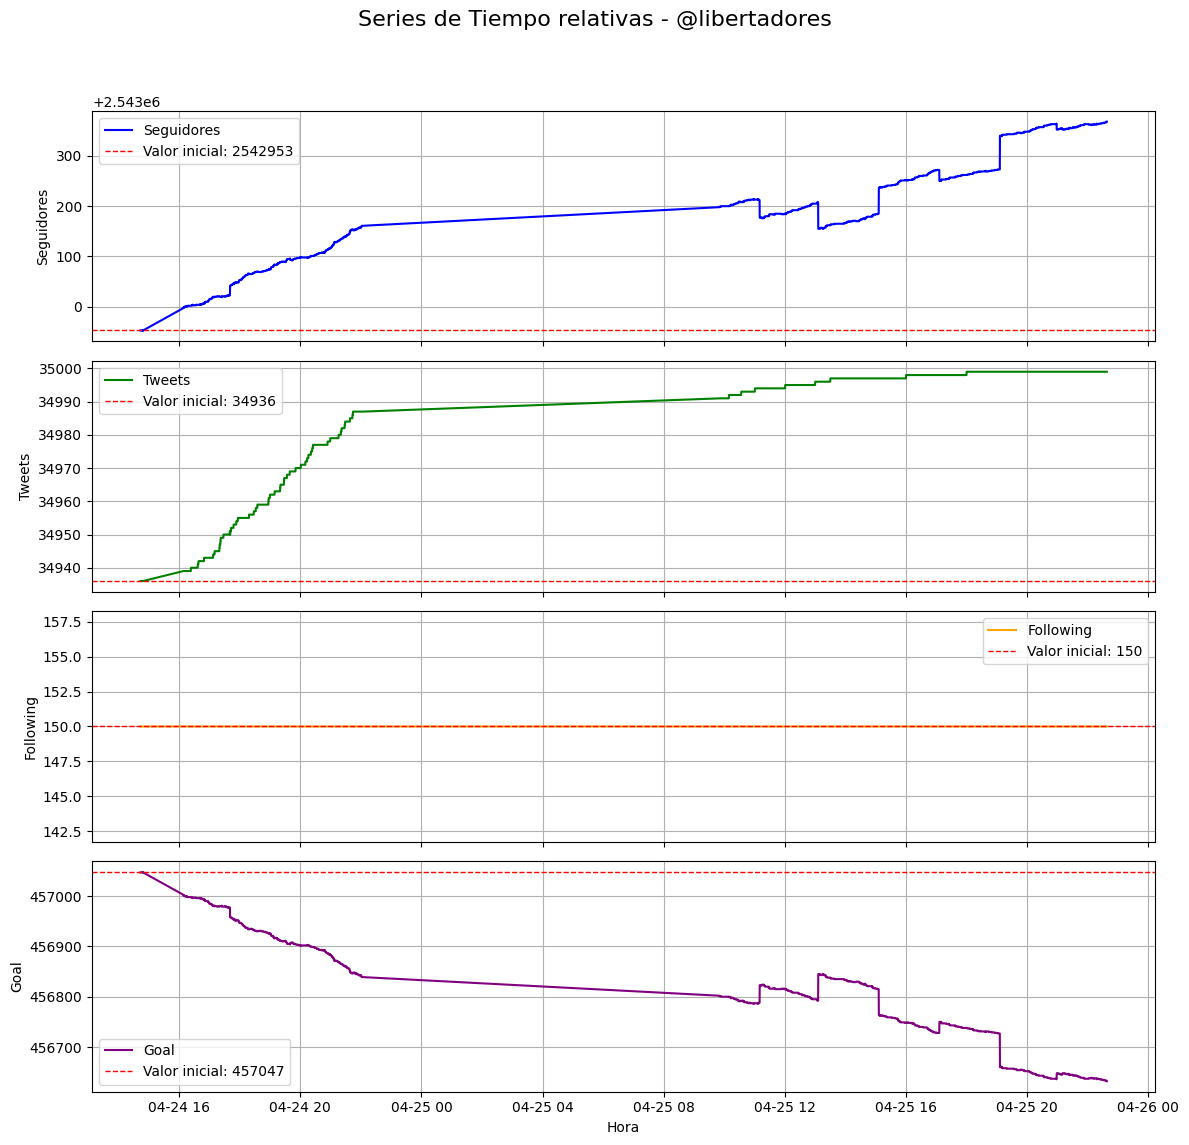

In [25]:
graficar_serie("2025-04-24 14:43:04", "2025-04-25 22:38:09", "seguidores_Libertadores_limpio.csv")